# A* Motion Planning

In [290]:
# The autoreload extension will automatically load in new code as you edit files, 
# so you don't need to restart the kernel every time
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from P1_astar import DetOccupancyGrid2D, AStar
from utils import generate_planning_problem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:
# from asl_tb3_lib.navigation import TrajectoryPlan
from utils import TrajectoryPlan

## Simple Environment
(Please submit resulting plot from this section in your write-up)
### Workspace

In [292]:
width = 10
height = 10
obstacles = [((6,7),(8,8)),((2,2),(4,3)),((2,5),(4,7)),((6,3),(8,5))]
occupancy = DetOccupancyGrid2D(width, height, obstacles)

### Starting and final positions

In [293]:
x_init = (1, 9)
x_goal = (9, 1)

### Run A* planning

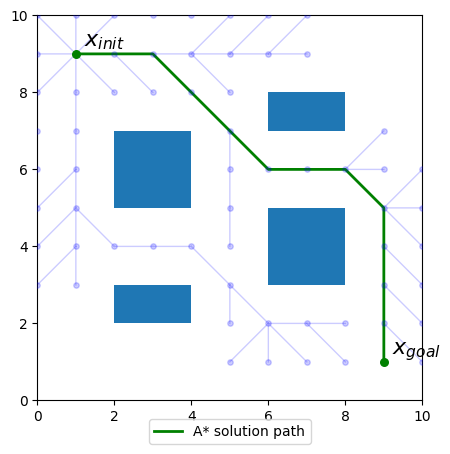

In [294]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy)
if not astar.solve():
    print("No path found")
else:
    plt.rcParams['figure.figsize'] = [5, 5]
    astar.plot_path()
    astar.plot_tree()

## Random Cluttered Environment
### Generate workspace, start and goal positions
(Try changing these and see what happens)

In [295]:
width = 10
height = 10
num_obs = 60
min_size = .5
max_size = 1

occupancy, x_init, x_goal = generate_planning_problem(width, height, num_obs, min_size, max_size)

### Run A* planning

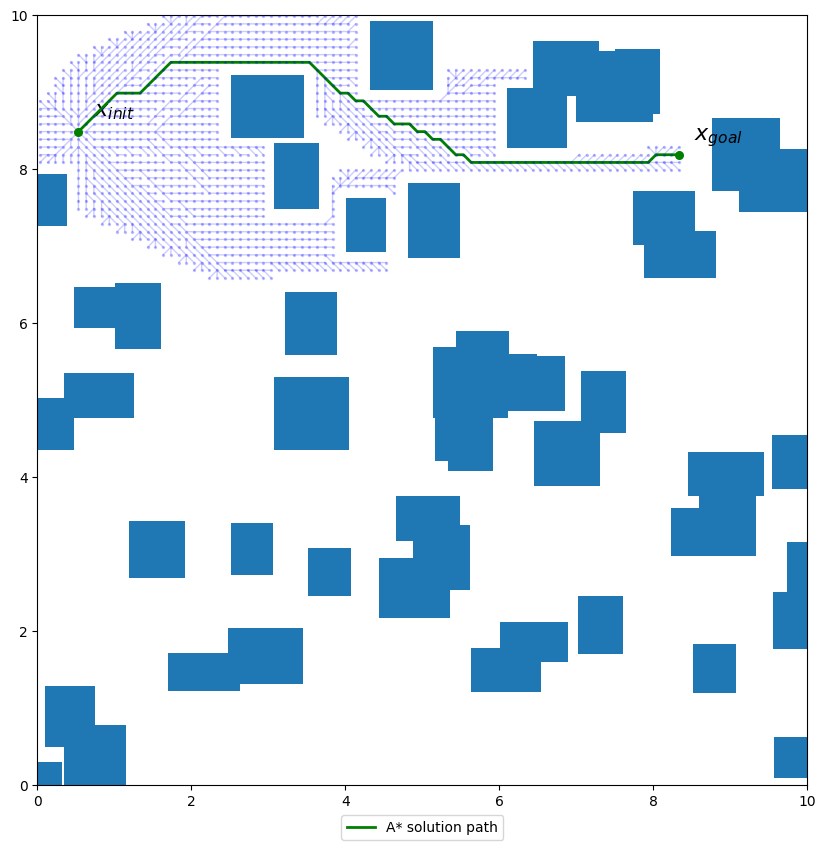

In [296]:
astar = AStar((0, 0), (width, height), x_init, x_goal, occupancy, resolution=0.1)
if not astar.solve():
    print("No path found! (This is normal, try re-running the block above)")
else:
    plt.rcParams['figure.figsize'] = [10, 10]
    astar.plot_path()
    astar.plot_tree(point_size=2)

In [297]:
# collision checker to use when optimizing the spline alpha in trajectory optimization
def check_for_collisions(path_x_spline, path_y_spline, ts):
    for t in ts:
        x = scipy.interpolate.splev(t, path_x_spline)
        y = scipy.interpolate.splev(t, path_y_spline)
        if not astar.is_free((x, y)):
            return True
    return False

# Smooth Trajectory 

In [298]:
def compute_smooth_plan(path, v_desired=0.15, spline_alpha=0.05) -> TrajectoryPlan:
    # Ensure path is a numpy array
    path = np.asarray(path)

    # Compute the time stamps for each waypoint
    ts = [0]
    for i in range(1, len(path)):
        distance = np.linalg.norm(path[i] - path[i-1])
        time = distance / v_desired
        ts.append(ts[-1] + time)
    ts = np.array(ts)

    # Assign high weights to start and end points to enforce them to be the same as the original path
    weights = np.ones(len(path))
    weights[0] = 1e10  # Strong weight on start
    weights[-1] = 1e10  # Strong weight on end

    # Dichotomic search for the best spline_alpha
    low, high = 0.0, 50.0
    best_spline_alpha = spline_alpha
    best_path_x_spline = None
    best_path_y_spline = None

    while high - low > 1e-3:
        mid = (low + high) / 2
        path_x_spline = scipy.interpolate.splrep(ts, path[:, 0], w=weights, k=3, s=mid)
        path_y_spline = scipy.interpolate.splrep(ts, path[:, 1], w=weights, k=3, s=mid)
        if check_for_collisions(path_x_spline, path_y_spline, ts):
            high = mid
        else:
            low = mid
            best_spline_alpha = mid
            best_path_x_spline = path_x_spline
            best_path_y_spline = path_y_spline

    # Fit cubic splines to the x and y coordinates of the path with the best spline_alpha
    if best_path_x_spline is None or best_path_y_spline is None:
        best_path_x_spline = scipy.interpolate.splrep(ts, path[:, 0], w=weights, k=3, s=best_spline_alpha)
        best_path_y_spline = scipy.interpolate.splrep(ts, path[:, 1], w=weights, k=3, s=best_spline_alpha)

    path_x_spline = best_path_x_spline
    path_y_spline = best_path_y_spline
    print(f"Best spline_alpha: {best_spline_alpha}")

    return TrajectoryPlan(
        path=path,
        path_x_spline=path_x_spline,
        path_y_spline=path_y_spline,
        duration=ts[-1],
    )


In [299]:
# construct a trajectory plan
plan = compute_smooth_plan(astar.path)

Best spline_alpha: 0.060272216796875


In [300]:
# plot AStar path v.s. smoothed path
# astar_path = np.asarray(astar.path)
# smoothed_path = plan.smoothed_path()

# plt.plot(astar_path[:,0], astar_path[:,1], 'b-', label='Original Path')
# plt.plot(smoothed_path[:, 0], smoothed_path[:, 1], 'r-', label='Smoothed Path')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.xlim([0, width])
# plt.ylim([0, height])
# plt.title('Path Smoothing')
# plt.grid()

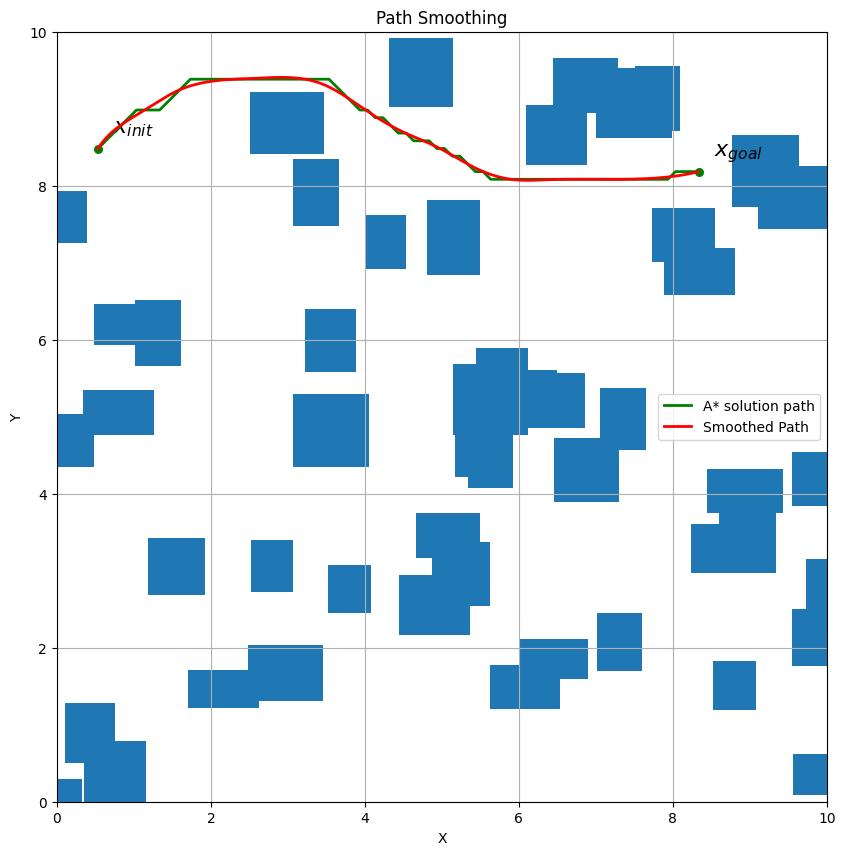

In [301]:
astar_path = np.asarray(astar.path)
smoothed_path = plan.smoothed_path()

# Plot the paths using the updated plot_path method
astar.plot_paths(smoothed_path=smoothed_path)